# Find all of the dippers in the ZTF dataset

This notebook processes the full ZTF dataset to look for dips and creates a new AXS dataset with the results.

# Setup

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc

import dipper

In [11]:
%matplotlib inline

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

# Process the full ZTF dataset

Warning! This takes a long time to run. With the latest dipper code, it is ~300 core hours. It is recommended to increase the number of cores that spark is running on before you execute this (e.g, in the spark setup change `.config('spark.master', "local[6]")` which uses 6 cores to something larger. It is also possible to run on AWS with hundreds or even thousands of cores.

In [5]:
ztf = catalog.load('ztf_aug2020_combined')

In [6]:
ztf.count()

1353725594

In [7]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
result = (
    ztf
    .exclude_duplicates()
    .where(
        (ztf["nobs_g"] >= 10)
        | (ztf["nobs_r"] >= 10)
        | (ztf["nobs_i"] >= 10)
    )
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            ztf['mjd_g'],
            ztf['mag_g'],
            ztf['magerr_g'],
            ztf['xpos_g'],
            ztf['ypos_g'],
            ztf['catflags_g'],
            ztf['mjd_r'],
            ztf['mag_r'],
            ztf['magerr_r'],
            ztf['xpos_r'],
            ztf['ypos_r'],
            ztf['catflags_r'],
            ztf['mjd_i'],
            ztf['mag_i'],
            ztf['magerr_i'],
            ztf['xpos_i'],
            ztf['ypos_i'],
            ztf['catflags_i']
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significance") >= 5)
    )
)

catalog.save_axs_table(result, 'wtf_aug2020_asymmetric_3', repartition=True)

CPU times: user 11.2 s, sys: 4.77 s, total: 16 s
Wall time: 22h 33min 16s


In [5]:
cc = catalog.load('wtf_aug2020_asymmetric_3')

In [6]:
cc.count()

1065600

In [53]:
%%time

# Run the dip detection query on the full ZTF dataset on spark
dip_selection = (
    cc
    .exclude_duplicates()
    # .where(cc['dip.significance'] > 100000)
    .where(
        (sparkfunc.col("dip.dip_night_count") >= 5)
        & ~sparkfunc.isnan(sparkfunc.col("dip.asymmetry_score"))
        & (sparkfunc.col("dip.rms_ratio") >= 3)
        & (sparkfunc.col("dip.frac_20") < 0.1)
        & (sparkfunc.col("dip.diff_ratio") < 3)
        & (sparkfunc.col("dip.asymmetry_significance") > 2)
    )
    .sort(sparkfunc.col('dip.asymmetry_significance').desc())
)

catalog.save_axs_table(dip_selection, 'wtf_aug2020_dip_candidates')

CPU times: user 68.5 ms, sys: 24.5 ms, total: 93 ms
Wall time: 3min 11s


In [54]:
dip_cat = catalog.load('wtf_aug2020_dip_candidates')
dip_cat.count()

596

In [60]:
# Load the best candidates
best_dippers = (
    dip_cat
    .exclude_duplicates()
    .sort(sparkfunc.col('dip.asymmetry_significance').desc())
    .collect()
)

In [61]:
print(len(best_dippers))

596


In [62]:
cmap = {
    'g': 'g',
    'r': 'r',
    'i': 'purple',
}

def measure_lc(lc, plot=False):
    result = dipper.measure_dip_row(lc)

    if result['significance'] > 0 and plot:
        plt.figure(figsize=(20, 4))

        for band in ['g', 'r', 'i']:
            mjd, mag, magerr = dipper.filter_ztf_observations(lc[f'mjd_{band}'], lc[f'mag_{band}'], lc[f'magerr_{band}'], lc[f'xpos_{band}'], lc[f'ypos_{band}'], lc[f'catflags_{band}'])
            mjd, mag, magerr, ref_scale = dipper.parse_light_curve(mjd, mag, magerr)

            if len(mjd) > 0:
                plt.errorbar(mjd, mag, magerr, fmt='o', c=cmap[band])

        plt.axvline(result['dip_start_mjd'], c='k', ls='--')
        plt.axvline(result['dip_end_mjd'], c='k', ls='--')
        plt.axvline(result['window_start_mjd'], c='k')
        plt.axvline(result['window_end_mjd'], c='k')
        dt = (result['window_end_mjd'] - result['window_start_mjd'])
        plt.xlim(result['window_start_mjd'] - 2*dt, result['window_end_mjd'] + 2*dt)

        plt.title(f"{lc['ps1_objid']}: {result['asymmetry_significance']:.3f}")
        plt.title(f"Asymmetry significance: {result['asymmetry_significance']:.3f}")

        plt.axvline(result['left_max_time'])
        plt.axvline(result['right_max_time'])
        plt.gca().invert_yaxis()

In [63]:
id_map = {row['ps1_objid']: row for row in best_dippers}

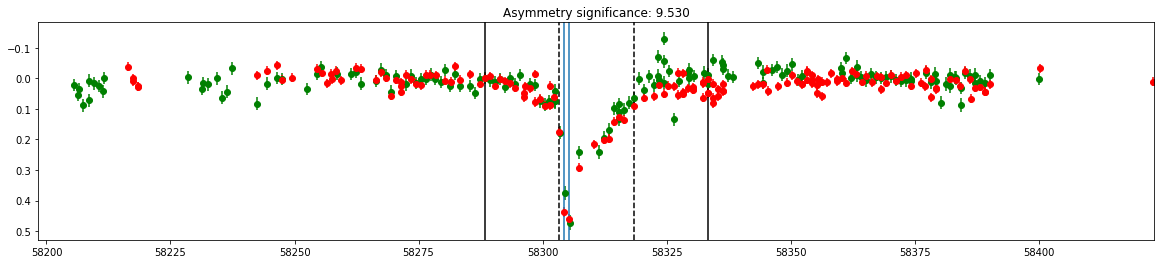

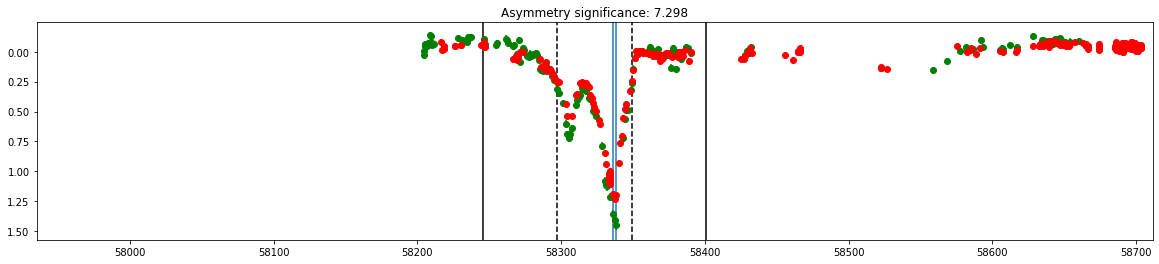

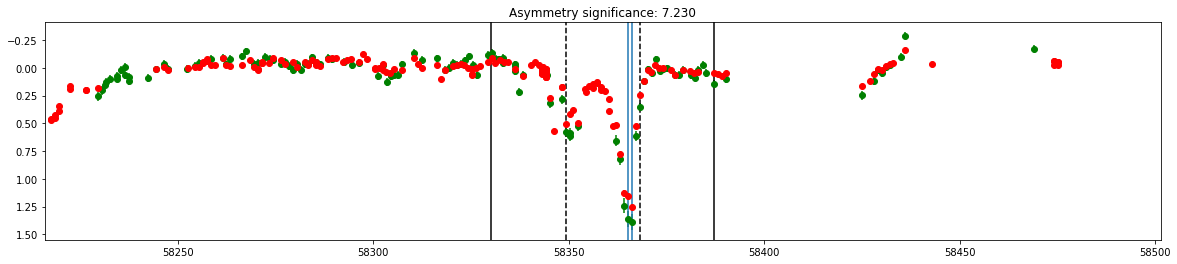

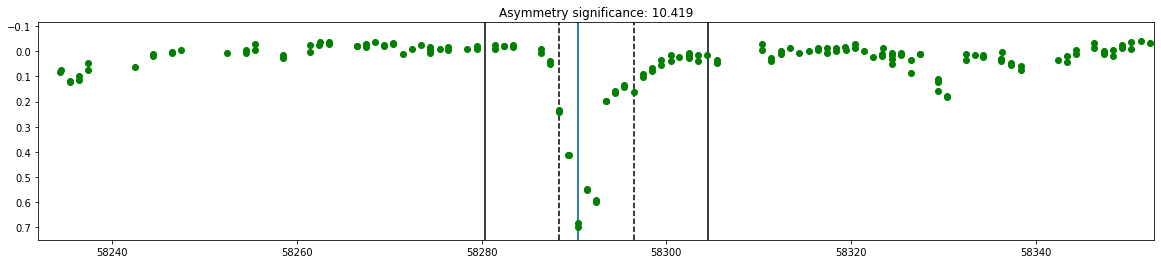

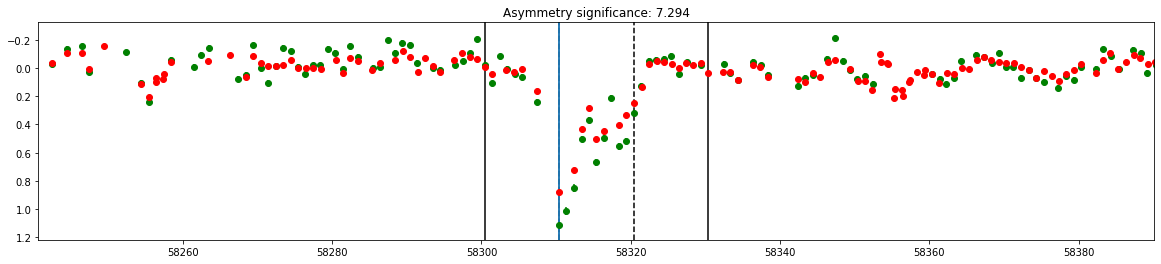

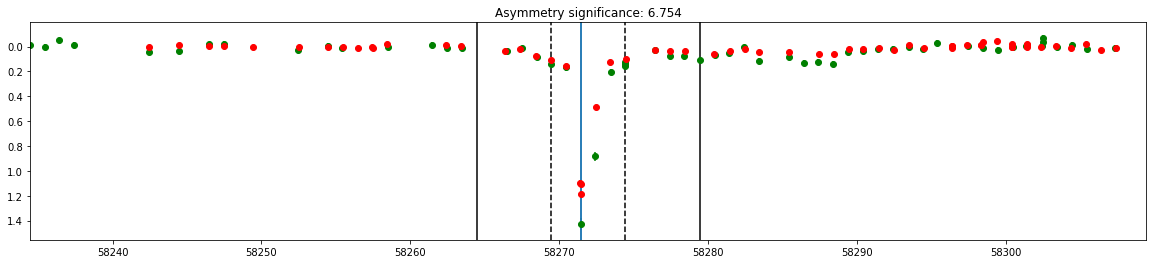

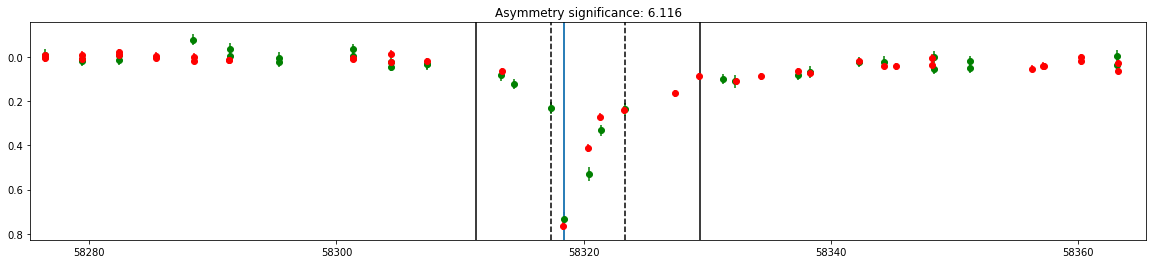

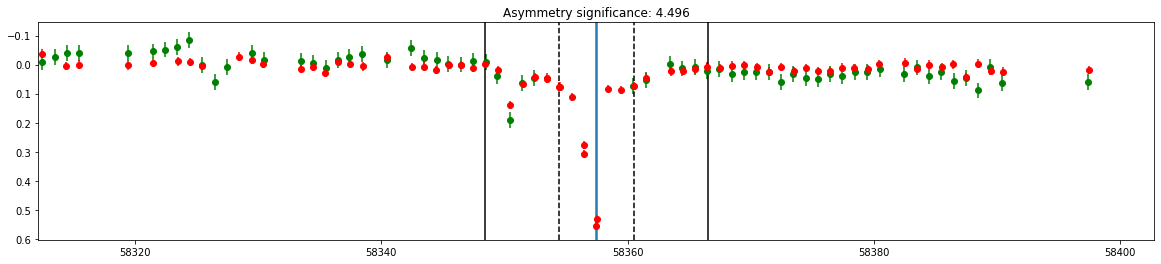

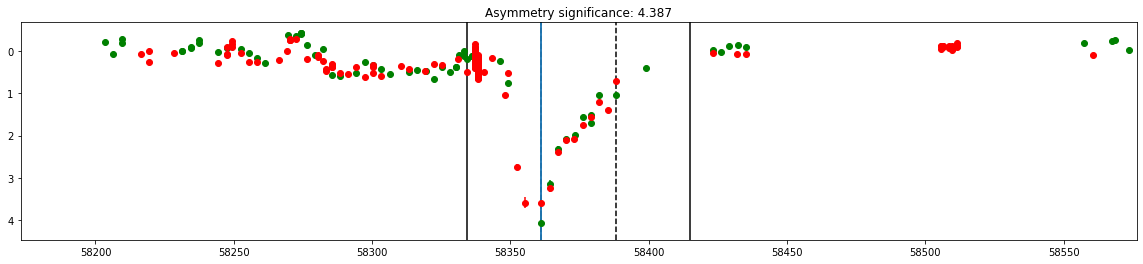

In [65]:
# Selected light curves
indices = [80, 143, 148, 57, 144, 166, 199, 303, 315]

for idx in indices:
    lc = best_dippers[idx]
    measure_lc(lc, plot=True)

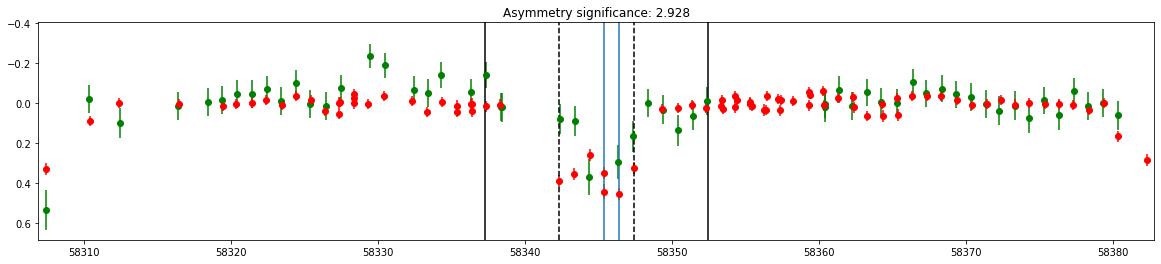

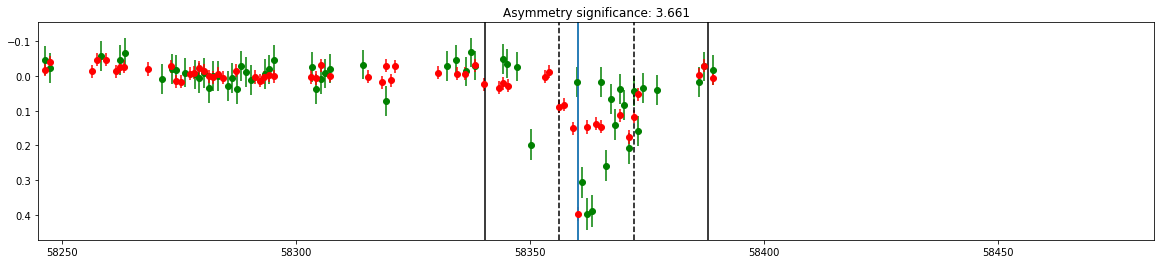

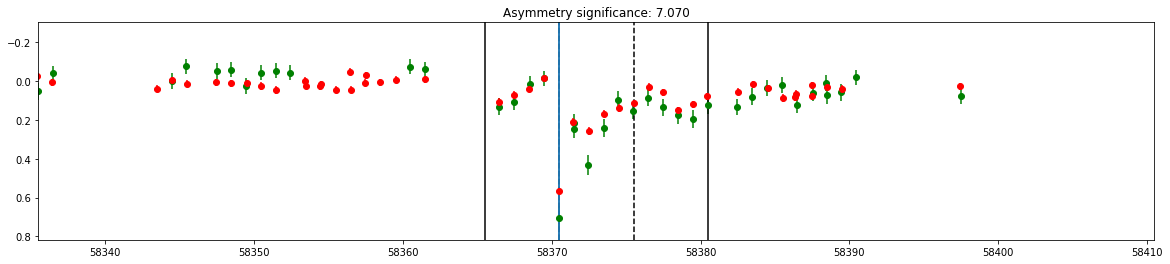

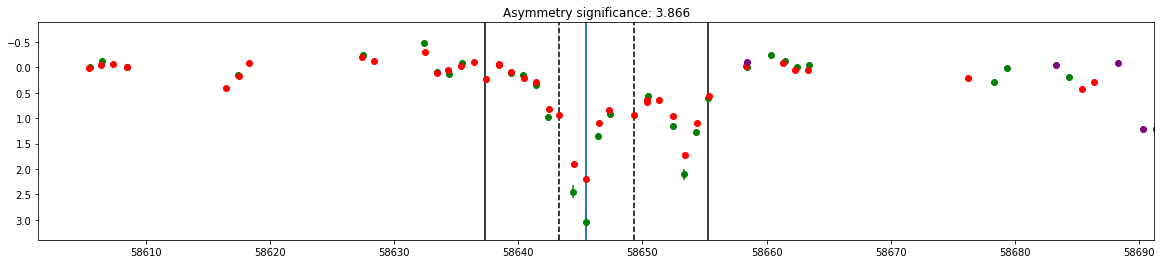

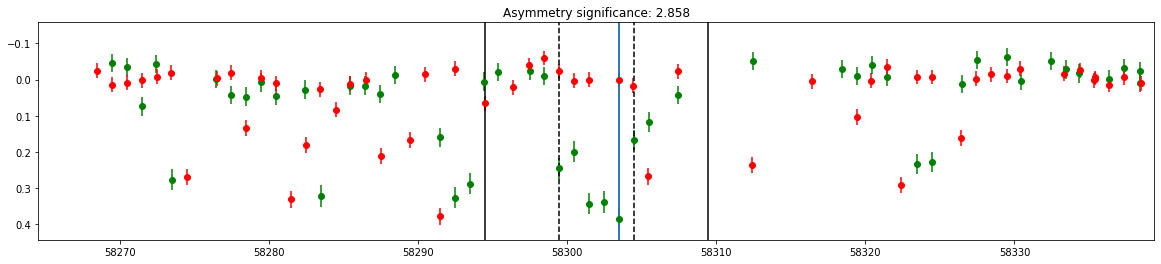

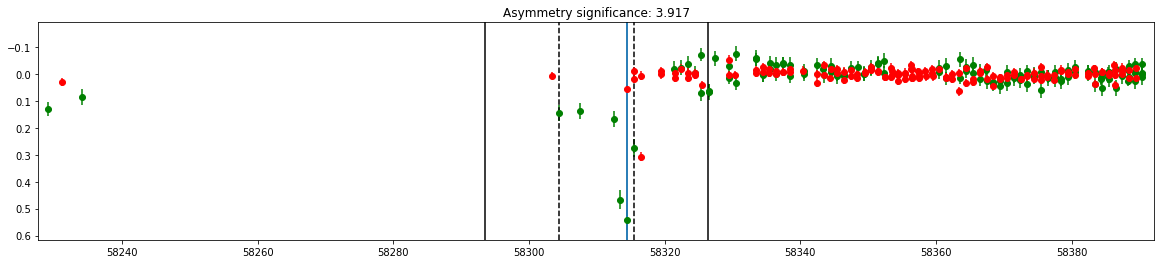

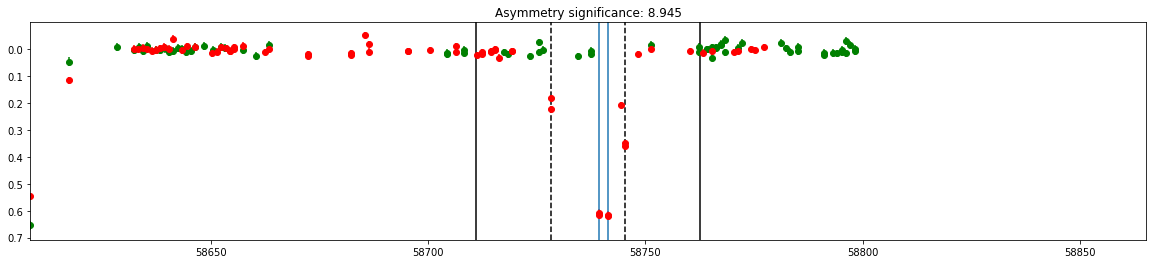

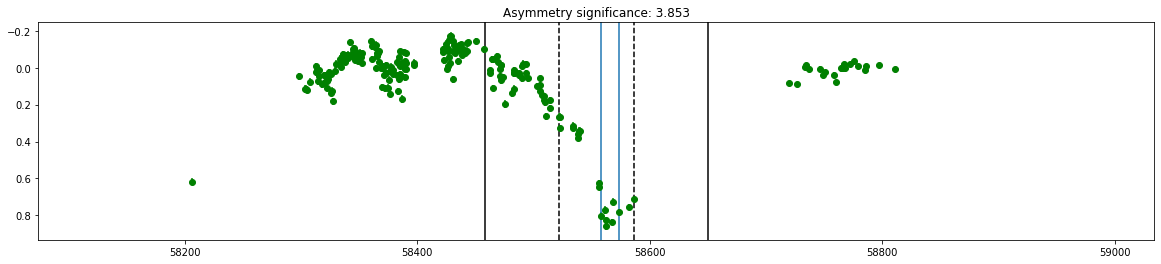

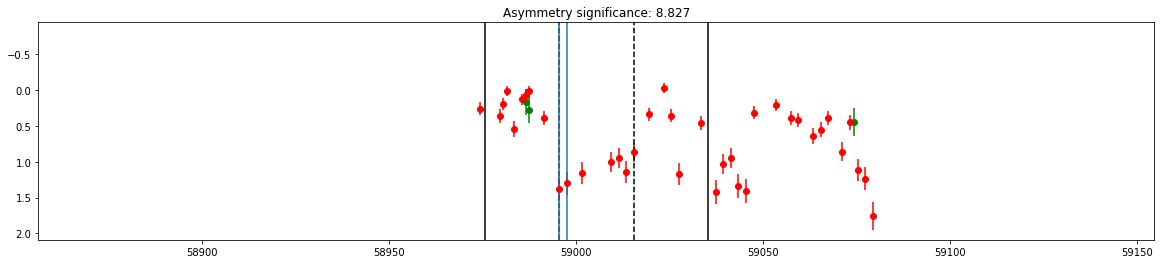

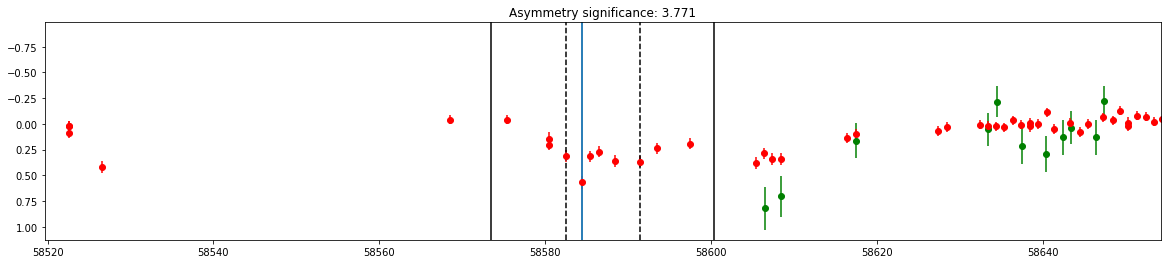

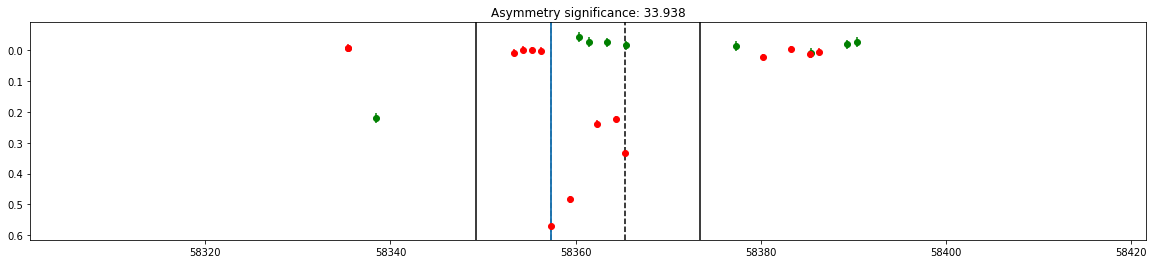

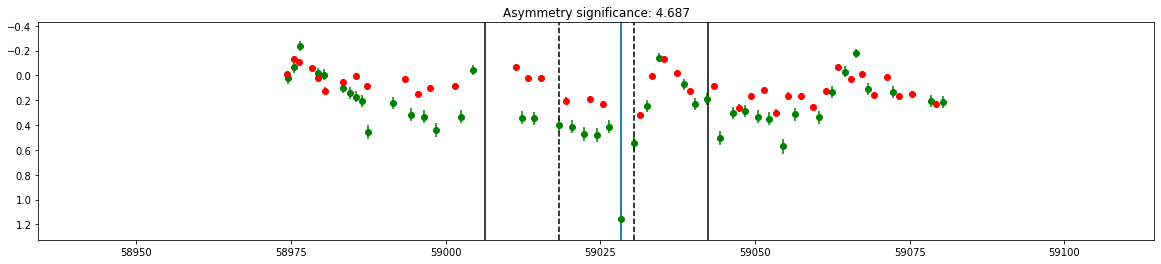

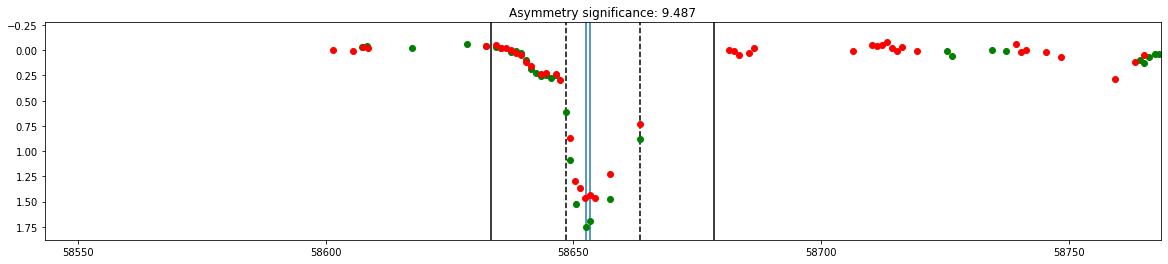

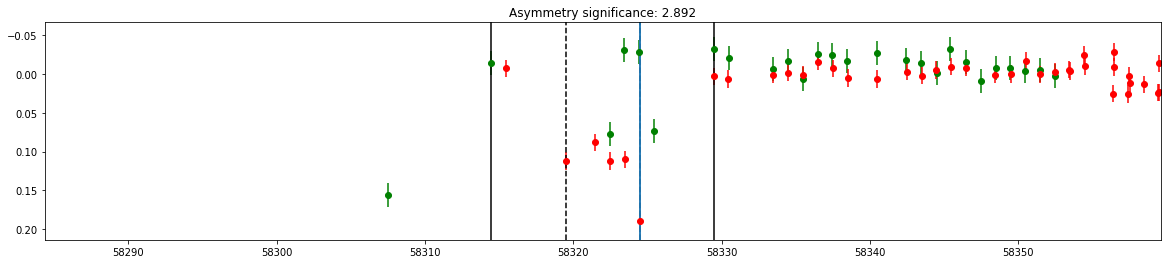

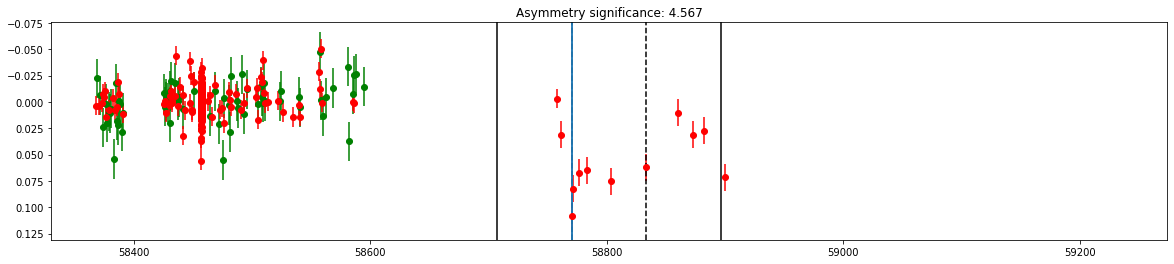

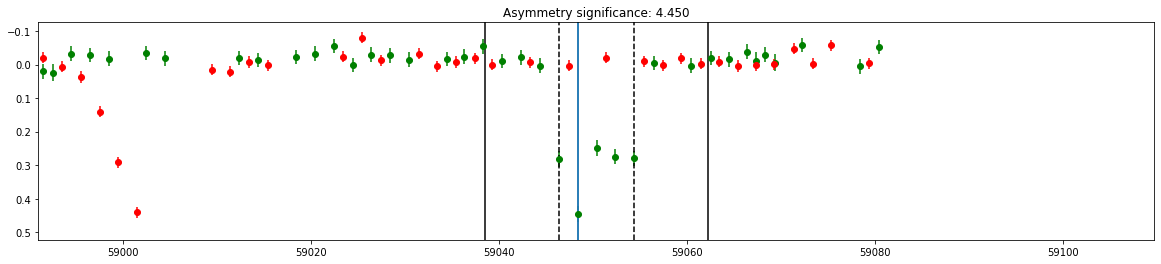

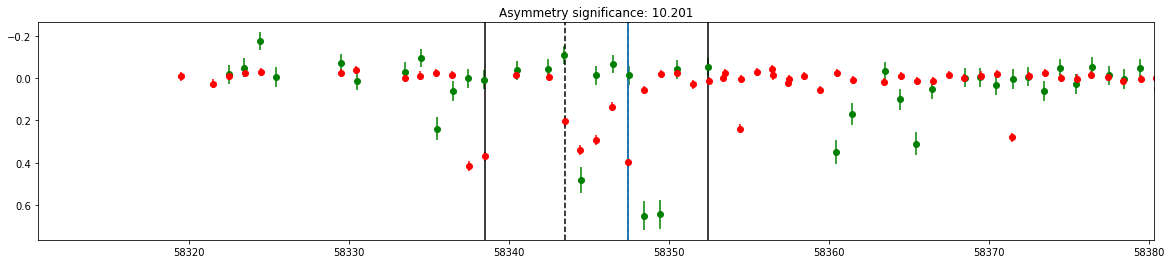

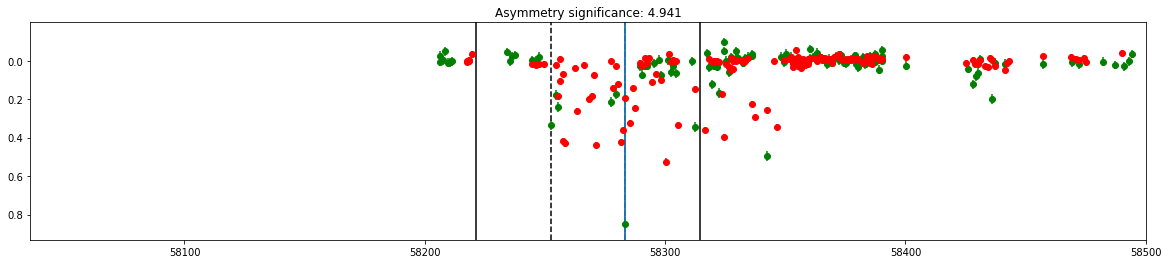

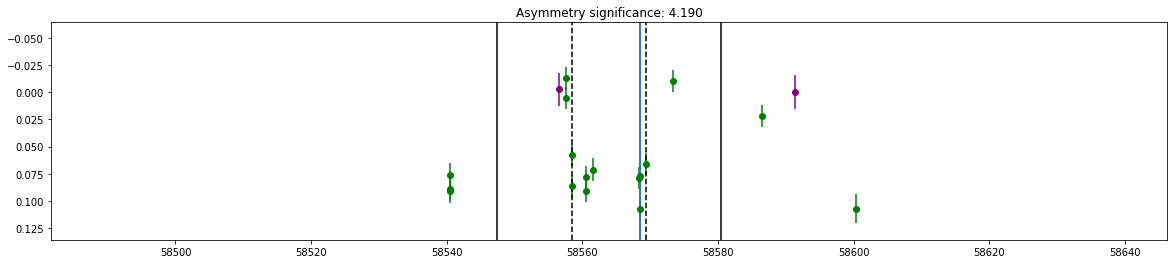

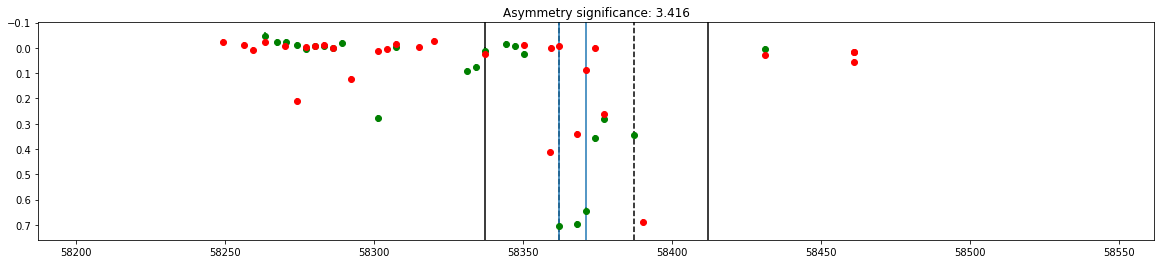

In [66]:
# Random light curves
for idx in np.random.choice(np.arange(len(best_dippers)), 20):
    lc = best_dippers[idx]
    measure_lc(lc, plot=True)